In [71]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importer le fichier potato-disease.zip depuis kaggle ici ou depuis le pc local
# !unzip potato-disease.zip
# !rm potato-disease.zip
# !mv potato-disease/ drive/MyDrive/datasets/
# !ls drive/MyDrive/datasets/potato-disease

Potato___Early_blight  Potato___healthy  Potato___Late_blight


In [73]:
import tensorflow as tf
from tensorflow import keras
models = keras.models
layers = keras.layers
import matplotlib.pyplot as plt

In [74]:
#path of the directories that contains images for diffrent type of potatos
PATH="drive/MyDrive/datasets/potato-disease"
healthyPotatos_folder=PATH+"/Potato___healthy"
PotatoLateBlight_folder=PATH+"/Potato___Late_blight"
PotatoEarlyBlight_folder=PATH+"/Potato___Early_blight"
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3 #we have rgb pictures

In [75]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    shuffle=True,
    image_size=(256, 256),
    batch_size=32
)

Found 2152 files belonging to 3 classes.


In [76]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

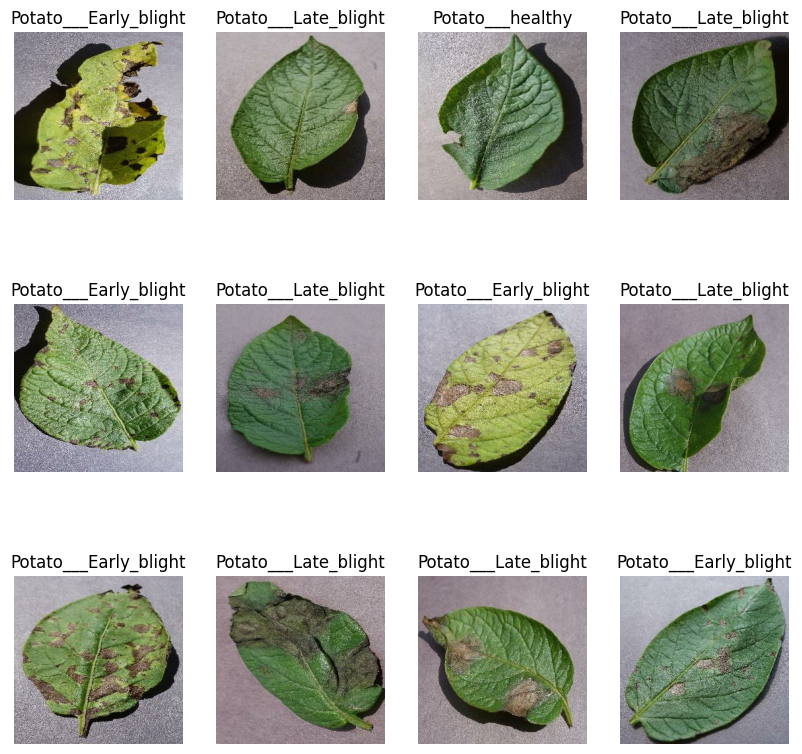

In [77]:
# print(len(dataset))
# print(68*32)#32 batches
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
  # print("tensor = ", image_batch[0].shape)
  # print("labels for the selected images in the current batch ", label_batch.numpy())
  for i in range(12):
      f = plt.subplot(3, 4, i+1)
      # print("labels of the current image = ", label_batch[i].numpy())
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[label_batch[i].numpy()])
      plt.axis("off")

i'll use
80% for training

and

20% (10% validation, 10% testing)

In [78]:
train_size = 0.8
train_size*len(dataset)

54.400000000000006

In [79]:
training_dataset = dataset.take(54)
print(len(training_dataset))
reste_of_dataset = dataset.skip(54)
print(len(reste_of_dataset))

54
14


In [80]:
validation_size = 0.1
print(len(dataset)*validation_size)
testing_dataset = reste_of_dataset.take(6)
validation_dataset = reste_of_dataset.skip(6)
print(len(validation_dataset))

6.800000000000001
8


In [81]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [82]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [83]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [84]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [85]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [86]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [87]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [88]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [90]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 175ms/step - accuracy: 0.5028 - loss: 0.9359 - val_accuracy: 0.5573 - val_loss: 0.8916
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6045 - loss: 0.8057 - val_accuracy: 0.7760 - val_loss: 0.5289
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7891 - loss: 0.4873 - val_accuracy: 0.9010 - val_loss: 0.2810
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8861 - loss: 0.2911 - val_accuracy: 0.8958 - val_loss: 0.2691
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8895 - loss: 0.3179 - val_accuracy: 0.9167 - val_loss: 0.1849
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9082 - loss: 0.2478 - val_accuracy: 0.9375 - val_loss: 0.1642
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9489 - loss: 0.1273 - val_accuracy: 0.9427 - val_loss: 0.1313
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9463 - loss: 0.1357 - val_accuracy: 0.9375 -

In [91]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9953 - loss: 0.0171


[0.014319629408419132, 0.99609375]

In [92]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [93]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [94]:
len(history.history['loss'])
history.history['loss'][:5]

[0.9032387733459473,
 0.7445778846740723,
 0.44133836030960083,
 0.2843957543373108,
 0.2880641222000122]

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

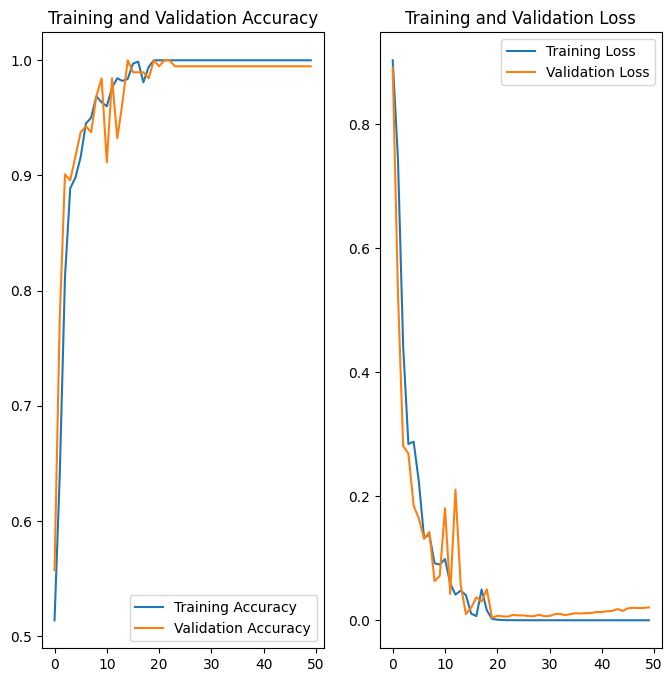

In [96]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
predicted label: Potato___Late_blight


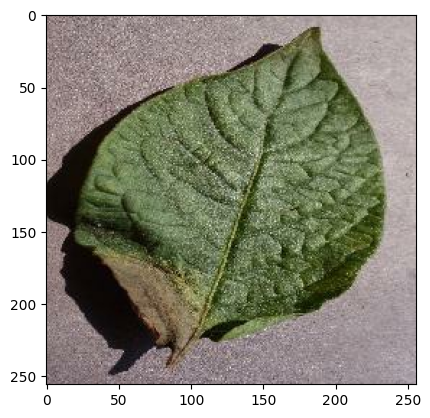

In [103]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [104]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


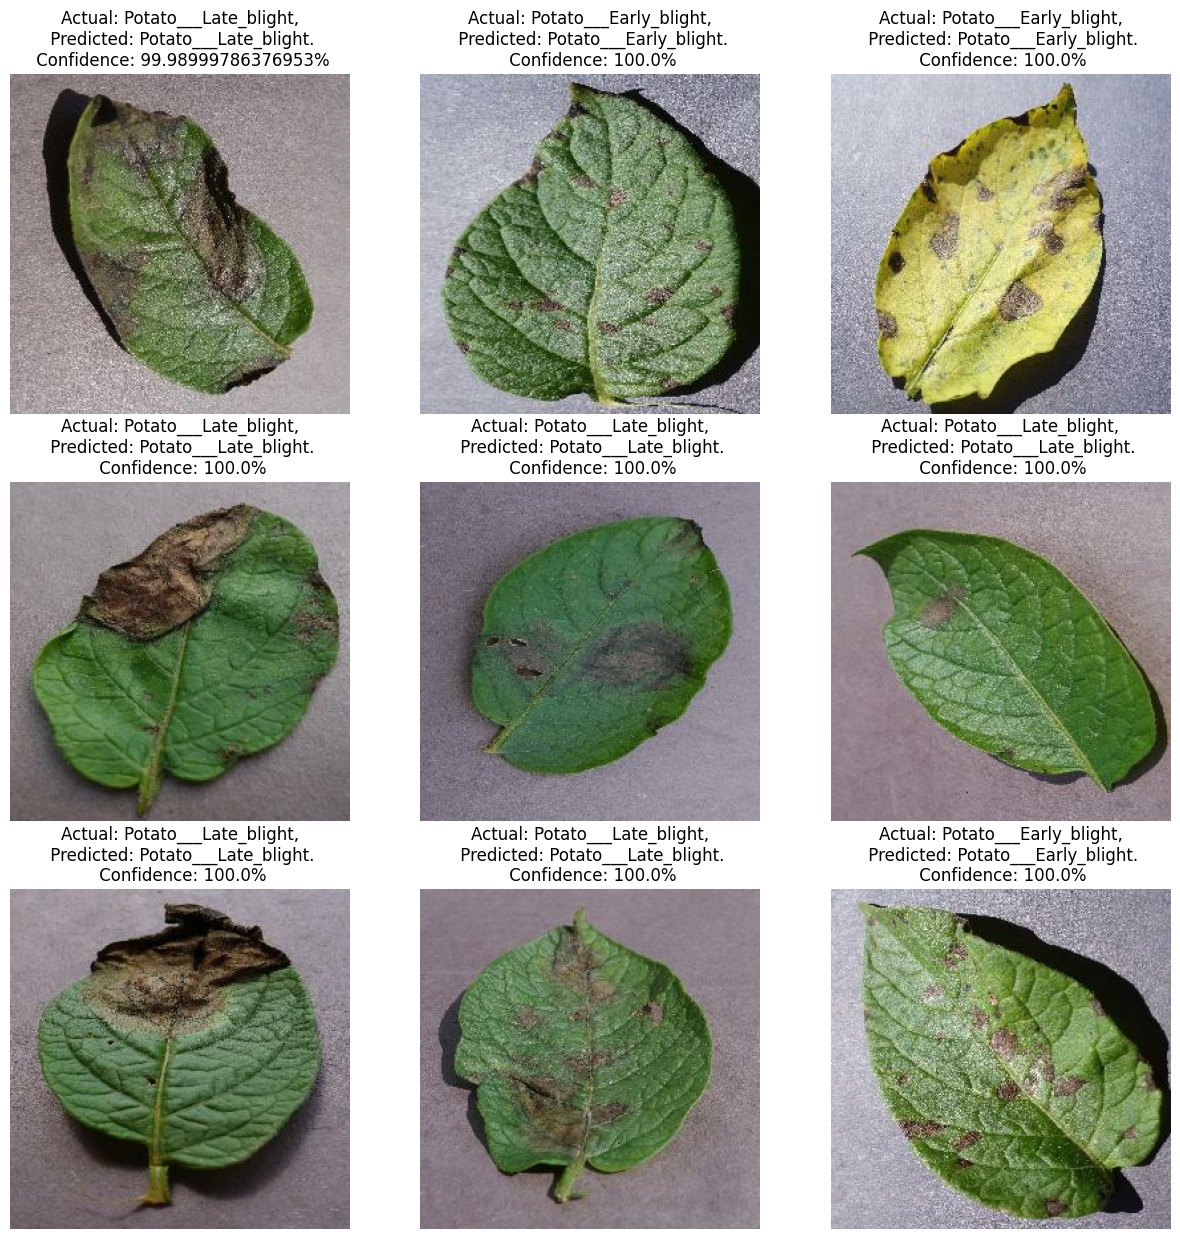

In [108]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [117]:
model.save("/content/drive/MyDrive/model/potatoes.h5")

In [129]:
import os
model_dir = '/content/drive/MyDrive/model'
existing_versions = [f for f in os.listdir(model_dir) if f.endswith('.h5')]
if existing_versions:
    versions = [int(f.split('_v')[1].split('.')[0]) for f in existing_versions if '_v' in f]
    new_version = max(versions) + 1 if versions else 1
else:
    new_version = 1
model_filename = f"potatoes_v{new_version}.h5"
model.save(f"{model_dir}/{model_filename}")
print(f"Model saved as: {model_filename}")

Model saved as: potatoes_v4.h5


In [136]:
!ls {model_dir}

potatoes_v1.h5
